# Sheet 4

In [125]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
import scipy.io
import math 
from numpy.linalg import inv
# Import data
A = np.genfromtxt("data/A.csv",delimiter=",")
B = np.genfromtxt("data/B.csv",delimiter=",")
C = np.genfromtxt("data/C.csv",delimiter=",")
Gamma = np.genfromtxt("data/Gamma.csv",delimiter=",")
L0 = np.genfromtxt("data/L0.csv",delimiter=",")
mu0 = np.genfromtxt("data/mu0.csv",delimiter=",")
Sigma = np.genfromtxt("data/Sigma.csv",delimiter=",")
u = np.genfromtxt("data/u.csv",delimiter=",")
x = np.genfromtxt("data/x.csv",delimiter=",")
z = np.genfromtxt("data/z.csv",delimiter=",")
z0 = np.genfromtxt("data/z0.csv",delimiter=",")


## Task 1. Kalman filter-smoother

### Retrieve an estimate for the latent states $z$ purely from the observations $x$ by implementing the Kalman filter recursion.

In [ ]:
# Defining quantities
T = 100
mu_t = np.empty((2,T))
K_t = [None]*T
L_t = [None]*T
V_t = [0]*T

In [127]:
# Initializing

K_t[0] = L0 @ B.T @ inv(B @ L0 @ B.T + Gamma)
V_t[0] = (np.identity(2) - K_t[0] * B) * L0
L_t[0] = A @ V_t[0] @ A.T + Sigma
mu_t[:, 0] = A @ mu0 + C * u[0] + K_t[0] @ (x[:, 0]- B @ (A @ mu0 + C * u[0]))

In [128]:
# Loop
for t in range(1,T):
    L_t[t] = A @ V_t[t-1] @ A.T + Sigma     
    K_t[t] = L_t[t-1] @ B.T @ inv(B @ L_t[t-1] @ B.T + Gamma)
    V_t[t] = (np.identity(2) - K_t[t] * B) * L_t[t-1]
    mu_t[:,t] = A @ mu_t[:,t-1] + C * u[t] + K_t[t] @ (x[:, t]- B @ (A @ mu_t[:,t-1]+ C * u[t]))

### Plot the obtained predicted latent states against the true latent states (in variable z)
**How well can you recover the true latent states? What could the drone be doing?**

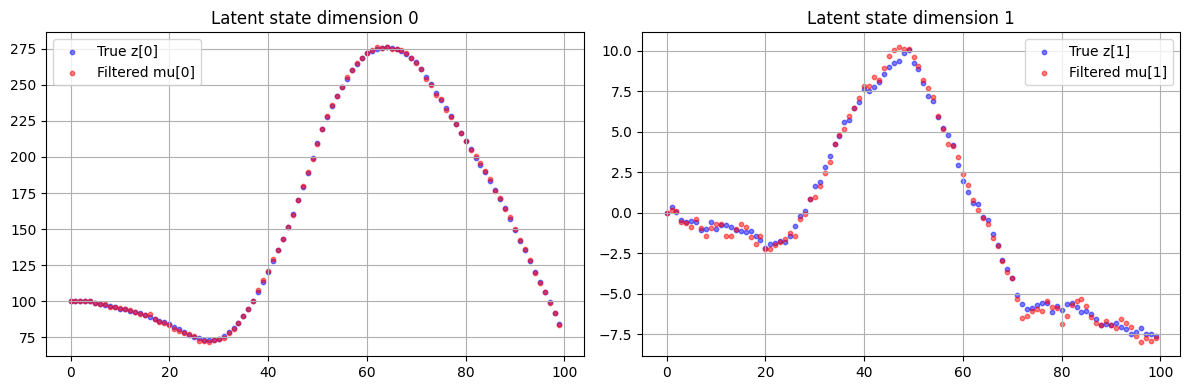

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].scatter(range(T), z[0, :], color="blue", s=10, alpha=0.5, label="True z[0]")
axes[0].scatter(range(T), mu_t[0, :], color="red", s=10, alpha=0.5, label="Filtered mu[0]")
axes[0].set_title("Latent state dimension 0")
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(range(T), z[1, :], color="blue", s=10, alpha=0.5, label="True z[1]")
axes[1].scatter(range(T), mu_t[1, :], color="red", s=10, alpha=0.5, label="Filtered mu[1]")
axes[1].set_title("Latent state dimension 1")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


We recover the latent states pretty well. Dimension 0 should correspond to the height of the drone and the dimension 1 to the velocity. So a guess regarding the activity of the drone would be that it was flying up and accelarating up until time 65, after which it starts to slow down and lose height. 

### Examine the parameter values of A and C. Why are they chosen the way they are?

In [120]:
A

array([[1., 1.],
       [0., 1.]])

$A$ models how the next latent state depends on the previous, letting $h_{t}, v_{t}$ respectively denote height and velocity we have
$$\begin{pmatrix} h_{t} \\ v_{t} \end{pmatrix} = A  \begin{pmatrix} h_{t-1} \\ v_{t-1} \end{pmatrix} + Cu_t + \epsilon_t= \begin{pmatrix} h_{t-1} + v_{t-1} \\ v_{t-1}\end{pmatrix} + Cu_t + \epsilon_t$$
Which is quite a sensible model for how the next height and velocity depends on the previous. 

In [124]:
C

array([0.2, 1. ])

$C$ models how the latent state depends on the control variable
$$\begin{pmatrix} h_{t} \\ v_{t} \end{pmatrix} = A z_{t-1} + C u_t + \epsilon_t= A z_{t-1} + \begin{pmatrix} 0.2 u_t \\ u_t \end{pmatrix} + \eta_t $$
It shows that the height is less susceptible to the control variable than the velocity. Their is a one to one correspondance between the control variable and the velocity. 

### Now implement the Kalman smoother.

In [163]:
# Intitialize
mu_tilde_t = np.empty((2,T))
mu_tilde_t[:, 99] = mu_t[:,99]

for t in range(T-2,-1,-1):
   mu_tilde_t[:, t] = mu_t[:, t] + V_t[t] @ A.T @inv(L_t[t]) @ (mu_tilde_t[:, t+1] - (A @ mu_t[:, t] + C * u[t])) 

**Plot the obtained predicted latent states against the true latent states (variable ’z’), and against the latent states obtained by only using the filter.**

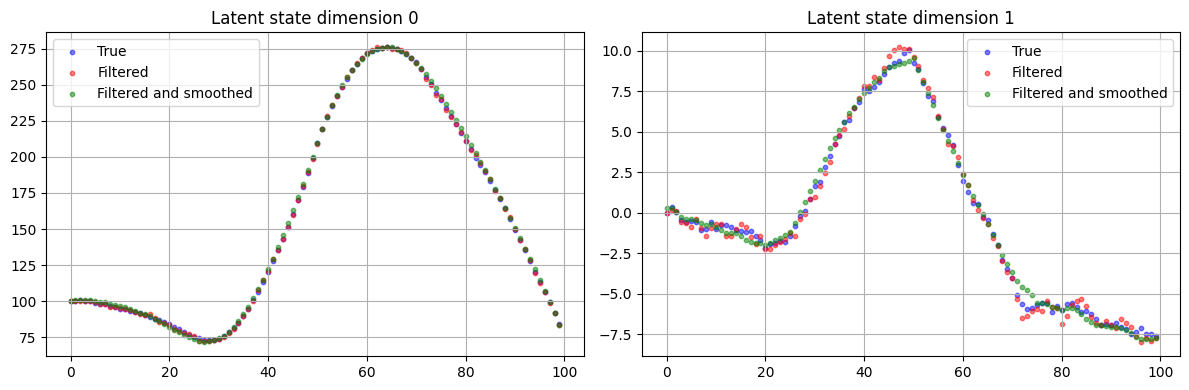

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].scatter(range(T), z[0, :], color="blue", s=10, alpha=0.5, label="True")
axes[0].scatter(range(T), mu_t[0, :], color="red", s=10, alpha=0.5, label="Filtered")
axes[0].scatter(range(T), mu_tilde_t[0, :], color="green", s=10, alpha=0.5, label="Filtered and smoothed")
axes[0].set_title("Latent state dimension 0")
axes[0].grid(True)
axes[0].legend()

axes[1].scatter(range(T), z[1, :], color="blue", s=10, alpha=0.5, label="True")
axes[1].scatter(range(T), mu_t[1, :], color="red", s=10, alpha=0.5, label="Filtered")
axes[1].scatter(range(T), mu_tilde_t[1, :], color="green", s=10, alpha=0.5, label="Filtered and smoothed")
axes[1].set_title("Latent state dimension 1")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [165]:
MSE_filter = np.mean((z - mu_t).flatten() * (z - mu_t).flatten())
MSE_filter_smoother = np.mean((z - mu_tilde_t).flatten() * (z - mu_tilde_t).flatten())
print(MSE_filter)
print(MSE_filter_smoother)

0.32495212758682546
1.1978611579368161
